# Obtaining the data from the Mona File

## Getting the path for Mona file

Using the method load_from_msp, the information inside the Mona file is being obtained.

In [1]:
import os

ROOT = os.path.abspath(os.path.join(os.getcwd()))
path = os.path.join(os.path.dirname(os.getcwd()), "data")
msp_file = os.path.join(path, "MoNA-export-GC-MS.msp")

## Importing Spectr from msp

In [2]:
from matchms.importing import load_from_msp
import numpy as np


spectrums = [s for s in load_from_msp(msp_file)]
print("Number of Spectra:", len(spectrums))

Number of Spectra: 14847


## Appliying filters to the spectra

Applied filters are:
* select_by_mz(s, **mz_from=0**, **mz_to=1000**)
* normalize_intensities(s)
* select_by_relative_intensity(s, **intensity_from=0.05**, **intensity_to=0.3**)

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity

def apply_my_filters(s):
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = normalize_intensities(s)
    s = select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1)
    return s


## Dividing spectra in groups of the same and different molecule

In [4]:
import random

def group_by_inchikey(spectrums):
    grouped_spectrum = []
    inchikeys = []
    for s in spectrums:
        inchikey = s.metadata.get('inchikey').split('-', 1)[0]
        if inchikey not in inchikeys:
            inchikeys.append(inchikey)
            grouped_spectrum.append([s]) 
        else:
            index = inchikeys.index(inchikey)
            grouped_spectrum[index].append(s)
    print(len(grouped_spectrum), "unique molecules")
    return grouped_spectrum

def grouped_by_same_mol(spectrums):
    group_spectra_same_molecule = random.sample([k for k in group_by_inchikey(spectrums) if len(k) == 2], 1000)
    return group_spectra_same_molecule

def grouped_by_diff_mol(spectrums):
    group_spectra_diff_molecule = [[g[0]] for g in grouped_by_same_mol(spectrums)]

    for k, e in enumerate(group_spectra_diff_molecule):
        diff_mol = random.sample(spectrums, 1)
        while e[0].metadata['inchikey'].split('-', 1)[0] == diff_mol[0].metadata['inchikey'].split('-', 1)[0]:
            diff_mol = random.sample(spectrums, 1)
        group_spectra_diff_molecule[k].append(diff_mol[0])
    
    return group_spectra_diff_molecule

In [5]:
same_mol_spectra = grouped_by_same_mol(spectrums)
diff_mol_spectra = grouped_by_diff_mol(spectrums)

9006 unique molecules
9006 unique molecules


## Selecting a sample of a thousand pairs of spectra of the same and different molecule

In [6]:
import numpy as np

def select_1000_spectra(data):
    temp = [data[i] for i in range(1000)]
    return [[s[0], s[1]] for s in temp]
            
same_mol_one_k_sample = select_1000_spectra(same_mol_spectra)
diff_mol_one_k_sample = select_1000_spectra(diff_mol_spectra)


## Computing the Similarity score

The similarity algorithm used is Greedy with the Demuth powers due to the likeliness to Spec2Vec
Similarity scores of one thousand spectra is being computed

In [7]:
from datetime import datetime
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
import numpy as np

def calculate_similarity_scores(spectrums, tolerance=0.1):
    
    similarity_measure = CosineGreedy(tolerance, 0.0, 0.33)
    similarity_scores, n_matches = [], []
    
    for s in spectrums:
        similarity_temp, n_matches_temp = similarity_measure(s[0], s[1])
        similarity_scores.append(similarity_temp)
        n_matches.append(n_matches_temp)
    
    return similarity_scores, n_matches

## Applying filters to the spectra

Aplpying filters to the spectra and obtaining which of those spectra lose all their peaks after filtering

In [8]:

def filter_spectra(spectrums):
    temp_filtered, indexes_to_remove = [], []
    for k, spectre in enumerate(spectrums):
        temp_filtered.append([apply_my_filters(s) for s in spectre])
        indexes_to_remove += [k for s in temp_filtered[-1] if len(s.peaks.intensities) <= 0]
    return temp_filtered, indexes_to_remove

same_mol_one_k_sample_filtered, same_mol_indexes_to_remove = filter_spectra(same_mol_one_k_sample)

print(f"{len(same_mol_indexes_to_remove)} indexes to delete: ", same_mol_indexes_to_remove)

2 indexes to delete:  [653, 767]


## Removing spectra without peaks

the same indexes of spectra with no peaks are removed from the spectra which was not filtered, due to consistency when computing the difference in the similarity scores

In [9]:

same_mol_one_k_sample = [s for k, s in enumerate(same_mol_one_k_sample) if k not in same_mol_indexes_to_remove]
same_mol_one_k_sample_filtered = [s for k, s in enumerate(same_mol_one_k_sample_filtered) if k not in same_mol_indexes_to_remove]


## Applying filters to spectra of different molecules

In [10]:

diff_mol_one_k_sample_filtered, diff_mol_indexes_to_remove = filter_spectra(diff_mol_one_k_sample)

print(f"{len(diff_mol_indexes_to_remove)} indexes without peaks ater filtering")


0 indexes without peaks ater filtering


## Removing spectra without peaks

In [11]:

diff_mol_one_k_sample = [s for k, s in enumerate(diff_mol_one_k_sample) if k not in diff_mol_indexes_to_remove]
diff_mol_one_k_sample_filtered = [s for k, s in enumerate(diff_mol_one_k_sample_filtered) if k not in diff_mol_indexes_to_remove]

print(len(diff_mol_one_k_sample), " pairs of spectra of different molecule are remaining")

1000  pairs of spectra of different molecule are remaining


## Computing similarity scores for both group of spectra without filters

In [12]:

same_mol_similarities_unfiltered, same_mol_matches_unfiltered = calculate_similarity_scores(same_mol_one_k_sample, 0.5)
diff_mol_similarities_unfiltered, diff_mol_matches_unfiltered = calculate_similarity_scores(diff_mol_one_k_sample, 0.5)


## Computing similarity scores for both group of spectra after applying filters

In [13]:

same_mol_similarities_filtered, same_mol_matches_filtered = calculate_similarity_scores(same_mol_one_k_sample_filtered, 0.5)
diff_mol_similarities_filtered, diff_mol_matches_filtered = calculate_similarity_scores(diff_mol_one_k_sample_filtered, 0.5)


## Computing scores difference

In [14]:

def compute_differences(unfiltered_spectra, filtered_spectra):
    assert len(unfiltered_spectra) == len(filtered_spectra), "The size of the lists need to be the same"
    
    difference_scores = []
    for i in range(len(unfiltered_spectra)):
        difference = abs(unfiltered_spectra[i] - filtered_spectra[i])
        if np.isnan(difference):
            print(difference,i,  unfiltered_spectra[i], filtered_spectra[i])
        difference_scores.append(difference)
    return difference_scores

same_mol_score_differences = compute_differences(same_mol_similarities_unfiltered, same_mol_similarities_filtered)
diff_mol_score_differences = compute_differences(diff_mol_similarities_unfiltered, diff_mol_similarities_filtered)

print(f'Remaining Spectra of the same molecule: {len(same_mol_score_differences)}')
print(f'Remaining Spectra of different molecules: {len(diff_mol_score_differences)}')

Remaining Spectra of the same molecule: 998
Remaining Spectra of different molecules: 1000


 ## Plotting score difference

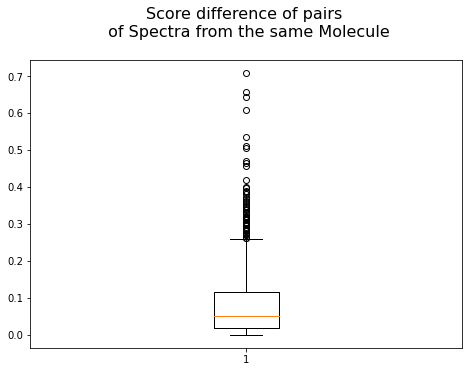

In [15]:
import matplotlib.pyplot as plt

def print_box_plot(data, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.title(title, fontsize=16)
    bp = ax.boxplot(data)
    plt.show()

print_box_plot(same_mol_score_differences, "Score difference of pairs \n of Spectra from the same Molecule\n")

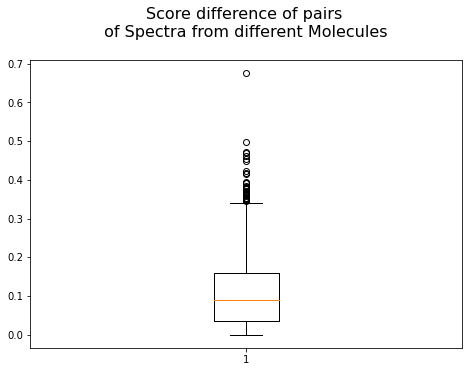

In [16]:
print_box_plot(diff_mol_score_differences, "Score difference of pairs \n of Spectra from different Molecules \n")